In [1]:
import numpy as np
import pandas as pd
import warnings # 경고 메시지 무시
warnings.filterwarnings(action='ignore')
# 한국어 형태소 분석기 중 성능이 가장 우수한 Mecab 사용
from konlpy.tag import Mecab
mecab = Mecab()
from tqdm import tqdm # 작업 프로세스 시각화
import re # 문자열 처리를 위한 정규표현식 패키지
from gensim import corpora # 단어 빈도수 계산 패키지
import gensim # LDA 모델 활용 목적
import pyLDAvis # LDA 시각화용 패키지
from collections import Counter # 단어 등장 횟수 카운트
from gensim.models.coherencemodel import CoherenceModel

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.sparse as sparse
import random
import implicit
from implicit.als import AlternatingLeastSquares as ALS

# %cd /home/user_3/medistream-recsys/Script
# from preprocessing import drop_columns,dict_to_column,dict_to_set,set_to_column,key_to_element

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Load Data

In [27]:
vectors = pd.read_json("/home/user_4/CBF/Token/final_tokens_0.json")

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
vectors

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,title,full_content,tokens
0,5d13115e32026c0b35383897,KCD 한방내과 진찰진단 가이드라인,한방내과 진찰진단 가이드라인 의 번째 큐레이션 상시판매 권승원의 한방내과 진찰...,"[변, 검사, 교수, 한, 의사, 스트셀러, 도로, 합편, 근거, 큐레이션, 의학,..."
1,5d9edfe70dabe405b156e213,우리 아이 감기,우리 아이 감기 우리 아이 감기부제 약물 남용과 과잉치료가 없는 새로운 감기 진료를...,"[의원, 절반, 환자, 도움, 한, 부분, 과, 진행, 처음, 활용, 소개, 안녕,..."
2,5e3cb2904267e105dfff13b3,통증치료를 위한 신경초음파와 하이드로다이섹션 테크닉,통증치료를 위한 신경초음파와 하이드로다이섹션 테크닉 출판사 리뷰년전 소수 ...,"[음파, 테크닉, 리뷰년, 지침, 공부, 환자, 고충, 학술, 의사, 불철, 오늘,..."
3,5e3d06b64267e105dfff13e0,의사들이 꼭 알고 있어야 하는 응급의학 실전지침서(1-2),의사들이 꼭 알고 있어야 하는 응급의학 실전지침서 의사들이 꼭 알고 있어야 하는 응...,"[지침, 서, 의사, 의학, 실전, 응급]"
4,5e3d0da94267e105dfff13ed,복부 초음파 정석,복부 초음파 정석 저자서문 초음파 검사는 임상 영역에서 청진기로 불...,"[청진, 검사, 음파, 불가결, 지식, 의료, 고분, 장점, 실제, 조작, 탐촉, ..."
...,...,...,...,...
3805,53555,"[나의 인턴 일지] Ep.04 한의대생, 퇴사를 했다.",나의 인턴 일지 한의대생 퇴사를 했다 선생님들 안녕하세요 꽤 오...,"[때, 일지, 선생, 인턴, 한의, 컨펌, 인사, 감상, 실습, 월, 대, 최고, ..."
3806,53850,초음파 케이스: shoulder impingement synd. (SASD burs...,초음파 케이스 세 남환 구급대원으로 운동 좋아하심 ...,"[형광, 건측, 빨간색, 어깨, 비교, 상근, 케이스, 대원, 팬, 우측, 음파, ..."
3807,53945,비판적으로 논문 읽기: 통계적 보정에 대해,비판적으로 논문 읽기 통계적 보정에 대해 얼마 전 를 앓고 난 뒤 남아 있는 여러...,"[뒤, 초록, 연구, 정, 종류, 논문, 사람, 저자, 감염, 선행, 길, 주석, ..."
3808,54190,[작가가 입사했다] Ep.09 작가가.. 혹사했다..,작가가 입사했다 작가가 혹사했다 여름 휴가 기간은 쏜살같이 지났고 여전히 메디스...,"[화재, 선물, 작가, 위워크, 땀, 휴가, 기, 피신, 기간, 월, 주변, 최고,..."


In [29]:
df1 = pd.read_json('/home/user_1/medistream-recsys/Script/YS/df_book_clean.json')
df = df1.copy()
df.shape

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(372, 15)

In [30]:
df2 = pd.read_json('/home/user_4/CBF/article_sum.json')
df2 = df2.copy()
df2.shape

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3438, 5)

In [31]:
df_des = pd.concat([df['description'],df2['content_tag_removed']])
df_des = pd.concat([df[['name_x','description']].rename(columns={'name_x':'title'}),df2[['title','content_tag_removed']].rename(columns={'content_tag_removed':'description'})], axis=0)
df_des = df_des.reset_index().reset_index().rename(columns={'level_0':'문서 번호'})

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
df_des

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,문서 번호,index,title,description
0,0,0,KCD 한방내과 진찰진단 가이드라인,의 번째 큐레이션 상시판매 권승원의 한방내과 진찰진단 가이드라인 의학은빠른속...
1,1,1,우리 아이 감기,우리 아이 감기부제 약물 남용과 과잉치료가 없는 새로운 감기 진료를 목표로 ...
2,2,2,통증치료를 위한 신경초음파와 하이드로다이섹션 테크닉,_ 출판사 리뷰년전 소수 인원이 모여 시작한 통증 공부 모임이 작은 불씨가 ...
3,3,3,의사들이 꼭 알고 있어야 하는 응급의학 실전지침서(1-2),의사들이 꼭 알고 있어야 하는 응급의학 실전지침서
4,4,4,복부 초음파 정석,_ 저자서문 초음파 검사는 임상 영역에서 청진기로 불릴 정도로 간편한...
...,...,...,...,...
3805,3805,3433,"[나의 인턴 일지] Ep.04 한의대생, 퇴사를 했다.",선생님들 안녕하세요! 꽤 오랜만에 글을 씁니다. 저 퇴사를 했습...
3806,3806,3434,초음파 케이스: shoulder impingement synd. (SASD burs...,# CASE 13 houlder iigeet yd. SASD uriti 37...
3807,3807,3435,비판적으로 논문 읽기: 통계적 보정에 대해,"얼마 전 COVID-19를 앓고 난 뒤 남아 있는 여러 증상들, 롱 코비드Log ..."
3808,3808,3436,[작가가 입사했다] Ep.09 작가가.. 혹사했다..,"여름 휴가 기간은 쏜살같이 지났고, 여전히 메디스트림은 바쁘다. 엎친데 덮..."


In [33]:
list(df_des[['문서 번호','title']])

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['문서 번호', 'title']

# Tokenize

In [34]:
#################################################################################
from gensim import corpora, models, similarities

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
des_tokenized = []
for doc in tqdm(df_des['description']):
    tokens = [token for token in mecab.nouns(doc) if len(token) > 1] # 각 행(책,아티클)마다의 형태소 분석 명사 추출
    des_tokenized.append(tokens)

len(des_tokenized)

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 3810/3810 [00:21<00:00, 177.02it/s]


3810

In [36]:
des_tokenized = []
for doc in vectors['tokens']:
    des_tokenized.append(doc)
len(des_tokenized)

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3810

In [37]:
from gensim import corpora
dictionary = corpora.Dictionary(des_tokenized) # 명사 집합들 사전화
corpus = [dictionary.doc2bow(text) for text in des_tokenized] # 각 문서마다 각 명사의 갯수 분석
print(corpus[3000])

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(1, 1), (50, 1), (52, 1), (56, 1), (60, 1), (86, 1), (90, 1), (93, 1), (160, 1), (174, 1), (224, 1), (232, 1), (264, 1), (396, 1), (481, 1), (528, 1), (546, 1), (609, 1), (610, 1), (748, 1), (767, 1), (797, 1), (933, 1), (1027, 1), (1033, 1), (1078, 1), (1467, 1), (1639, 1), (2113, 1), (2244, 1), (2410, 1), (2415, 1), (2811, 1), (2846, 1), (2895, 1), (3093, 1), (3350, 1), (3734, 1), (3977, 1), (3991, 1), (4514, 1), (4669, 1), (5046, 1), (5416, 1), (5419, 1), (5712, 1), (6069, 1), (6114, 1), (9568, 1), (13291, 1), (13292, 1)]


In [38]:
from itertools import islice
def take(n, iterable):
    return list(islice(iterable, n))
items_5 = take(5, dictionary.iteritems())
items_5

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, '가이드'), (1, '검사'), (2, '경험'), (3, '교수'), (4, '구성')]

In [39]:
print('Number of unique tokens: %d' % len(dictionary)) # roughly 400 less than in presentation
print('Number of articles: %d' % len(corpus)) # roughly 500 less than 

Number of unique tokens: 15140
Number of articles: 3810


/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
def tokenization_report(bow, article_number):
    # 선택한 문서의 단어 묶음 가져오기
    article_tokens = bow[article_number]
    # 해당 단어 묶음, 출현 빈도에 따라 sort
    sorted_tokens = sorted(article_tokens, key=lambda x: x[1], reverse=True)
    
    for i in range(len(bow[article_number])):
        print("Word {} (\"{}\") appears {} time(s).".format(sorted_tokens[i][0], 
                                                         dictionary[sorted_tokens[i][0]], 
                                                         sorted_tokens[i][1]))
tokenization_report(corpus, 0)

Word 0 ("가이드") appears 1 time(s).
Word 1 ("검사") appears 1 time(s).
Word 2 ("경험") appears 1 time(s).
Word 3 ("교수") appears 1 time(s).
Word 4 ("구성") appears 1 time(s).
Word 5 ("구절") appears 1 time(s).
Word 6 ("근거") appears 1 time(s).
Word 7 ("근래") appears 1 time(s).
Word 8 ("기록") appears 1 time(s).
Word 9 ("내과") appears 1 time(s).
Word 10 ("내용") appears 1 time(s).
Word 11 ("노력") appears 1 time(s).
Word 12 ("논문") appears 1 time(s).
Word 13 ("도로") appears 1 time(s).
Word 14 ("라인") appears 1 time(s).
Word 15 ("른속") appears 1 time(s).
Word 16 ("발표") appears 1 time(s).
Word 17 ("방약") appears 1 time(s).
Word 18 ("배치") appears 1 time(s).
Word 19 ("변") appears 1 time(s).
Word 20 ("변화") appears 1 time(s).
Word 21 ("병력") appears 1 time(s).
Word 22 ("상시") appears 1 time(s).
Word 23 ("서적") appears 1 time(s).
Word 24 ("선배") appears 1 time(s).
Word 25 ("스트셀러") appears 1 time(s).
Word 26 ("시행") appears 1 time(s).
Word 27 ("영상") appears 1 time(s).
Word 28 ("은빠") appears 1 time(s).
Word 29 ("의사") appears

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Determining Optimal Topic Number

In [41]:
import os
os.getcwd()
project_folder = os.getcwd()

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
topicnums = [1,5,10,15,20,25,30,35,40,45,50]
project_folder = os.getcwd()

ldamodels_bow = {}
for i in topicnums:
    random.seed(42)
    if not os.path.exists(project_folder+'/models4/ldamodels_bow_'+str(i)+'.lda'):
        %time ldamodels_bow[i] = models.LdaModel(corpus, num_topics=i, random_state=42, update_every=1, passes=10, id2word=dictionary,minimum_probability=0.01)
        ldamodels_bow[i].save(project_folder+'/models4/ldamodels_bow_'+str(i)+'.lda')
        print('ldamodels_bow_{}.lda created.'.format(i))
    else: 
        print('ldamodels_bow_{}.lda already exists.'.format(i))

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 7.72 s, sys: 7.58 ms, total: 7.73 s
Wall time: 7.72 s
ldamodels_bow_1.lda created.
CPU times: user 25.6 s, sys: 0 ns, total: 25.6 s
Wall time: 25.6 s
ldamodels_bow_5.lda created.
CPU times: user 26.3 s, sys: 4.42 ms, total: 26.3 s
Wall time: 26.3 s
ldamodels_bow_10.lda created.
CPU times: user 28 s, sys: 11.5 ms, total: 28 s
Wall time: 28 s
ldamodels_bow_15.lda created.
CPU times: user 27.8 s, sys: 15.6 ms, total: 27.8 s
Wall time: 27.8 s
ldamodels_bow_20.lda created.
CPU times: user 28.5 s, sys: 11.9 ms, total: 28.5 s
Wall time: 28.5 s
ldamodels_bow_25.lda created.
CPU times: user 30.3 s, sys: 11.9 ms, total: 30.4 s
Wall time: 30.4 s
ldamodels_bow_30.lda created.
CPU times: user 30.6 s, sys: 15.9 ms, total: 30.6 s
Wall time: 30.6 s
ldamodels_bow_35.lda created.
CPU times: user 38.7 s, sys: 15.9 ms, total: 38.7 s
Wall time: 38.8 s
ldamodels_bow_40.lda created.
CPU times: user 43.8 s, sys: 15.9 ms, total: 43.8 s
Wall time: 43.8 s
ldamodels_bow_45.lda created.
CPU times: 

In [44]:
import pickle
lda_topics = {}
for i in topicnums:
    lda_model = models.LdaModel.load(project_folder+'/models4/ldamodels_bow_'+str(i)+'.lda')
    lda_topics_string = lda_model.show_topics(i)
    #'0.037*"치료" + 0.022*"신경" + 0.021*"시술" + 0.018*"경우" + 0.017*"환자" + 0.016*"손상" + 0.016*"골절" + 0.016*"약침" + 0.015*"통증" + 0.012*"도침"'
    # 위 내용 정리
    lda_topics[i] = ["".join([c if c.isalpha() else " " for c in topic[1]]).split() for topic in lda_topics_string]

pickle.dump(lda_topics,open(project_folder+'/models4/pub_lda_bow_topics.pkl','wb'))

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# coherences, perplexities

|--|Perplexity|Topic Coherence|
|--|--|--|
|의미|확률 모델이 결과를 얼마나 정확하게 예측하는지.낮을수록 정확하게 예측.|토픽이 얼마나 의미론적으로 일관성 있는지.높을수록 의미론적 일관성 높음|
|주용도|동일 모델 내 파라미터에 따른 성능 평가할 때 주로 사용|해당 모델이 얼마나 실제로 의미있는 결과를 내는지|
|한계|Perplexity가 낮다고 해서, 결과가 해석 용이하다는 의미가 아님|평가를 진행하기 위해 다른 외부 데이터(코퍼스, 시소러스 등)가 필요|

In [45]:
coherences=[]
perplexities=[]
passes=[]
for i in topicnums:
    lda_model = models.LdaModel.load(project_folder+'/models4/ldamodels_bow_'+str(i)+'.lda')
    cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()

    coherences.append(coherence)
    perplexities.append(lda_model.log_perplexity(corpus))
    print("Cpherence",coherence)
    print('Perplexity: ', lda_model.log_perplexity(corpus),'\n\n')
    

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cpherence -1.6073577445279248
Perplexity:  -8.042591265986909 


Cpherence -1.8089558748658177
Perplexity:  -7.928571525288801 


Cpherence -2.4759192015394964
Perplexity:  -8.095694245246943 


Cpherence -3.3276806647242103
Perplexity:  -8.561888201019467 


Cpherence -4.363473652853294
Perplexity:  -8.791238887590314 


Cpherence -5.315513495445739
Perplexity:  -9.01411408586396 


Cpherence -2.9801830071846775
Perplexity:  -9.252234566162329 


Cpherence -5.754609495589387
Perplexity:  -9.449736685508674 


Cpherence -6.0765604266569415
Perplexity:  -9.657352594452552 


Cpherence -6.8131473530020195
Perplexity:  -9.898185943395577 


Cpherence -6.3799463809569374
Perplexity:  -10.100780918559122 




/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


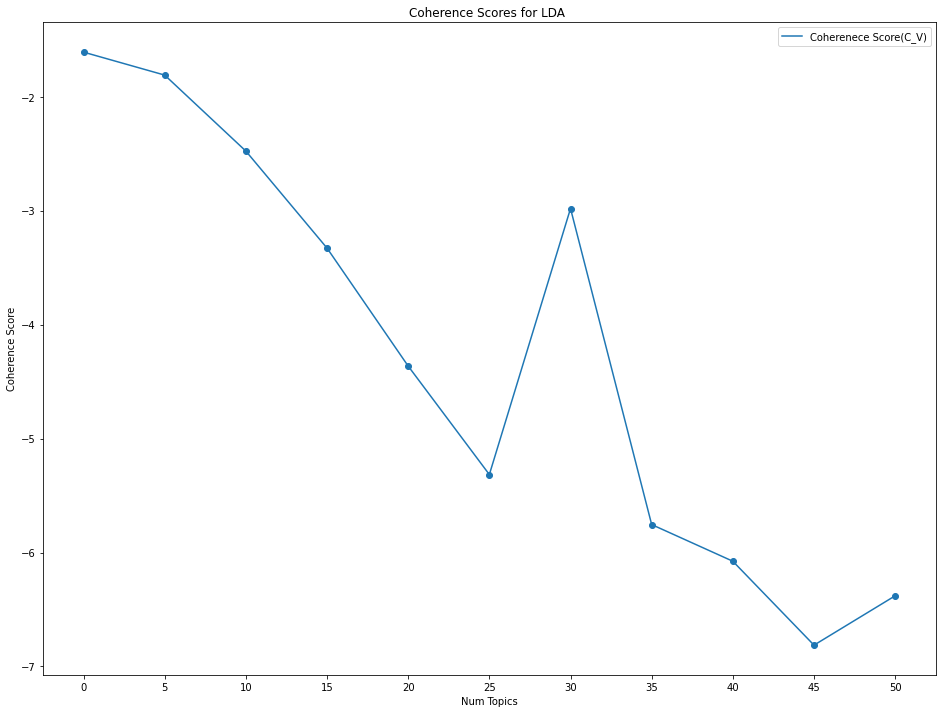

In [46]:
coherence_list = coherences
label = "Coherenece Score(C_V)"

x = range(0, 51, 5)
plt.figure(figsize=(16, 12))
plt.xticks(x)
plt.plot(x, coherence_list, label=label)
plt.scatter(x, coherence_list)
plt.title(f"Coherence Scores for LDA ")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(loc='best')
plt.show()

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


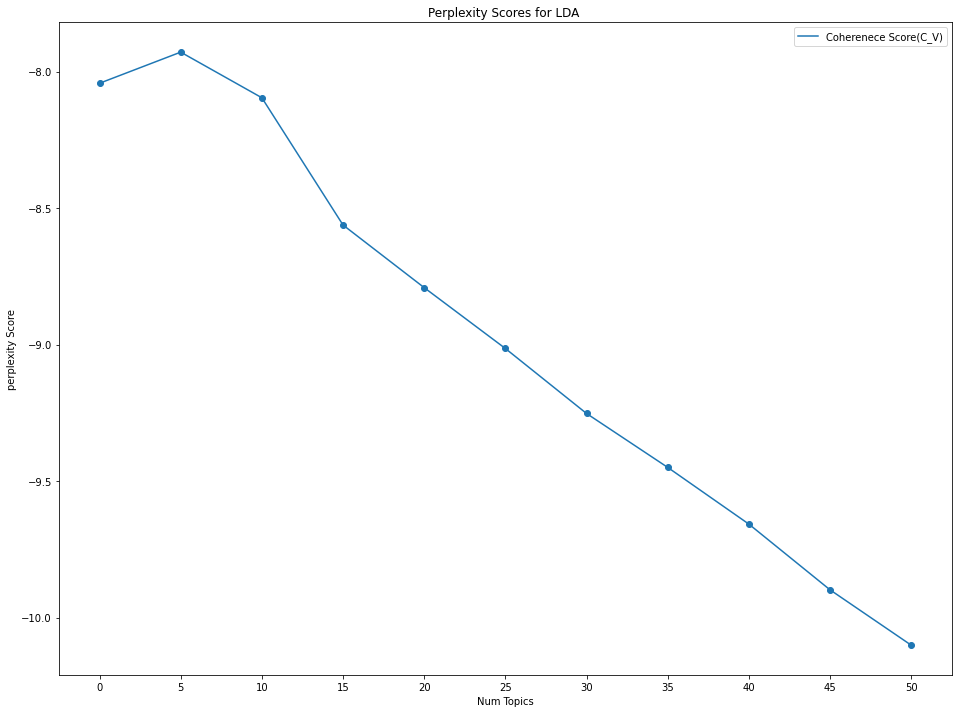

In [47]:
perplexity_list = perplexities
label = "Coherenece Score(C_V)"

x = range(0, 51, 5)
plt.figure(figsize=(16, 12))
plt.xticks(x)
plt.plot(x, perplexity_list, label=label)
plt.scatter(x, perplexity_list)
plt.title(f"Perplexity Scores for LDA ")
plt.xlabel("Num Topics")
plt.ylabel("perplexity Score")
plt.legend(loc='best')
plt.show()

## 자카드 유사도

In [48]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return float(len(intersection))/float(len(union))

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
lda_stability = {}
for i in range(0,len(topicnums)-1):
    jacc_sims = []
    for t1,topic1 in enumerate(lda_topics[topicnums[i]]):
        sims = []
        for t2,topic2 in enumerate(lda_topics[topicnums[i+1]]):
            sims.append(jaccard_similarity(topic1,topic2))    
        jacc_sims.append(sims)    
    lda_stability[topicnums[i]] = jacc_sims
    
pickle.dump(lda_stability,open(project_folder+'/models4/pub_lda_bow_stability.pkl','wb'))

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


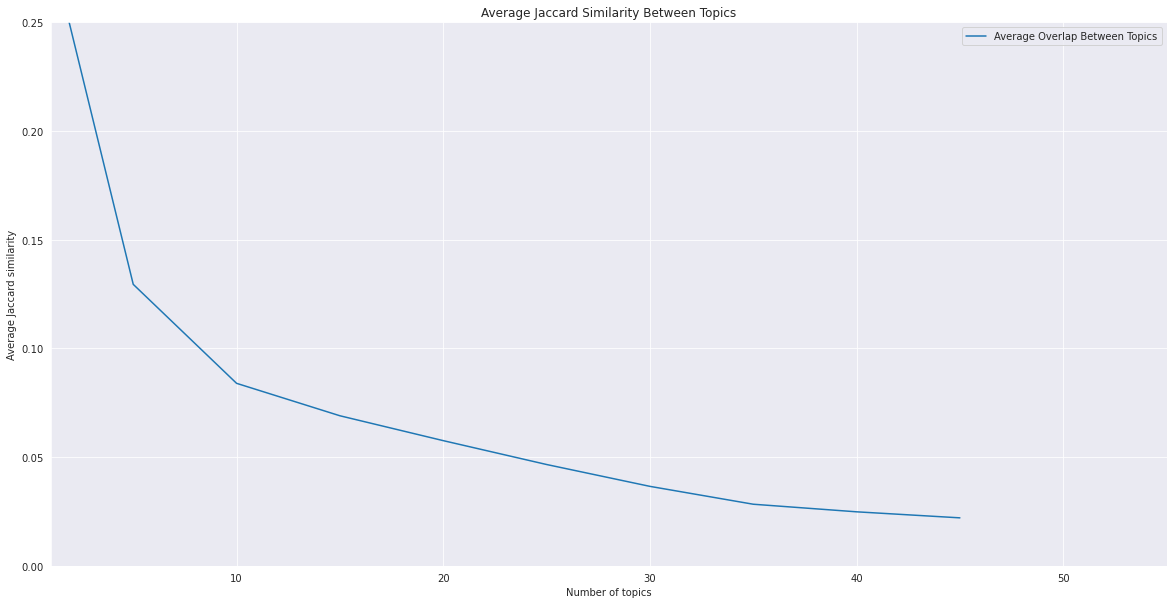

In [50]:
lda_stability = pickle.load(open(project_folder+'/models4/pub_lda_bow_stability.pkl','rb'))
mean_stability = [np.array(lda_stability[i]).mean() for i in topicnums[:-1]]

with sns.axes_style("darkgrid"):
    x = topicnums[:-1]
    y = mean_stability
    plt.figure(figsize=(20,10))
    plt.plot(x,y,label='Average Overlap Between Topics')
    plt.xlim([1, 55])
    plt.ylim([0, 0.25])
    plt.xlabel('Number of topics')
    plt.ylabel('Average Jaccard similarity')   
    plt.title('Average Jaccard Similarity Between Topics')
    plt.legend()    
    plt.show()

# Model 사용

Topic 선택 threshold : minimum_probability (float, optional) – Topics with a probability lower than this threshold will be filtered out.

In [81]:
num_topics = 45
lda_model_final = models.LdaModel.load(project_folder+'/models4/ldamodels_bow_'+str(num_topics)+'.lda')

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [82]:
from pprint import pprint
top_topics = lda_model_final.top_topics(corpus, topn=10)

avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

counter = 0
for topic in top_topics:
    print('Topic {}:'.format(counter))
    counter += 1
    pprint(topic)
    
pickle.dump(lda_topics,open(project_folder+'/models4/pub_lda_bow_topics.pkl','wb'))

Average topic coherence: -6.3124.
Topic 0:
([(0.018100496, '차'),
  (0.017927619, '참고'),
  (0.017483884, '보호'),
  (0.01708892, '수정'),
  (0.017076215, '아래'),
  (0.016962126, '안내'),
  (0.016898418, '법'),
  (0.016514547, '링크'),
  (0.01625904, '적용'),
  (0.016142113, '자료')],
 -1.221977332830755)
Topic 1:
([(0.037948232, '청구'),
  (0.03400462, '질문'),
  (0.031003848, '답변'),
  (0.02932602, '선생'),
  (0.026910217, '환자'),
  (0.025362115, '가능'),
  (0.021972742, '경우'),
  (0.02157541, '보험'),
  (0.021208126, '내용'),
  (0.020673933, '기본')],
 -1.2888654179906165)
Topic 2:
([(0.02462685, '환자'),
  (0.020157529, '통증'),
  (0.019149782, '치료'),
  (0.015670467, '증상'),
  (0.013498518, '검사'),
  (0.012859064, '진단'),
  (0.011210666, '경우'),
  (0.011118429, '때'),
  (0.010257081, '후'),
  (0.01016781, '내원')],
 -1.3185463026186937)
Topic 3:
([(0.01635575, '관절'),
  (0.011886235, '통증'),
  (0.01182567, '부위'),
  (0.011041162, '신경'),
  (0.010801754, '근육'),
  (0.009443367, '치료'),
  (0.00888934, '출처'),
  (0.008852229, '해부'),
  

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [83]:
corpus_lda_model = lda_model_final[corpus]
for article in corpus_lda_model[0]:
    print(article)

(5, 0.100889936)
(6, 0.25293547)
(26, 0.07791639)
(28, 0.552536)


/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [84]:
from operator import itemgetter
index_high_corr_list = []

index_counter = 0

for article in corpus_lda_model:
    highest_feature = max(article, key=itemgetter(1))[0]
    max_correlation = max(article, key=itemgetter(1))[1]
    index_high_corr_list.append([index_counter, highest_feature, max_correlation])
    index_counter += 1

index_high_corr_list[:5]

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[0, 28, 0.55253476],
 [1, 26, 0.3636088],
 [2, 33, 0.51663494],
 [3, 6, 0.86030334],
 [4, 6, 0.3375586]]

In [85]:
df_des[df_des.index==99]

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,문서 번호,index,title,description
99,99,99,혈맥약침,ㅇ


In [86]:
index_counter

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3810

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


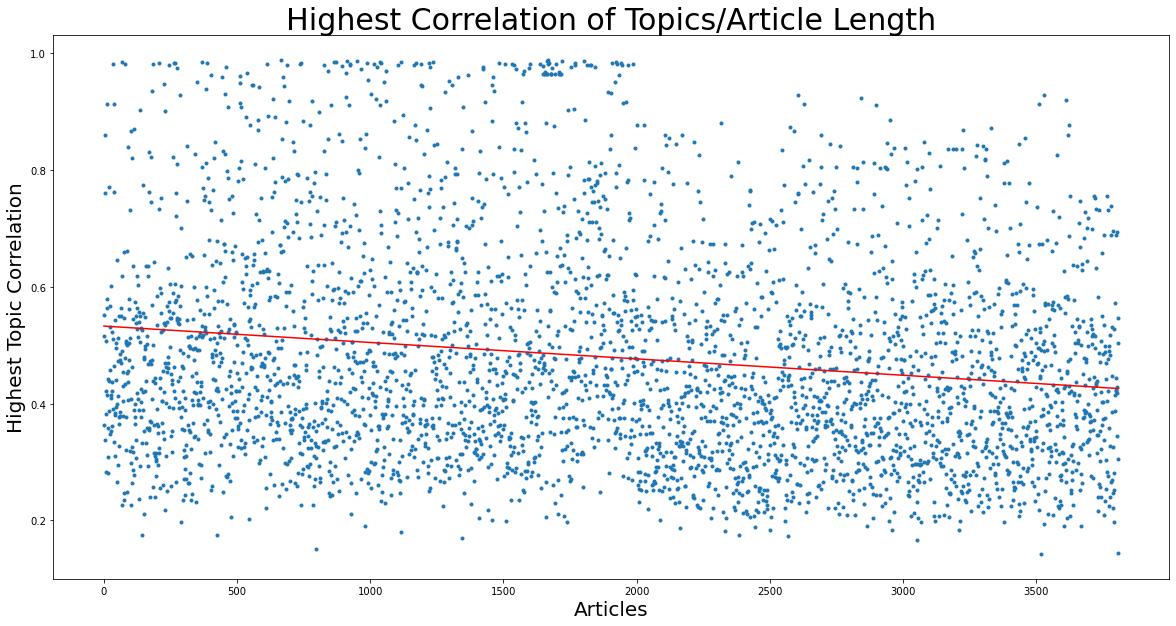

In [87]:
x = [tup[0] for tup in index_high_corr_list]
y = [tup[2] for tup in index_high_corr_list]

plt.figure(figsize=(20,10))
scatter = plt.plot(x,y, '.')
line = plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 'r')
plt.title('Highest Correlation of Topics/Article Length', fontsize=30)
plt.xlabel("Articles", fontsize=20)
plt.ylabel("Highest Topic Correlation", fontsize=20)
plt.show(scatter, line)

In [88]:
# pyLDAvis 불러오기
import pyLDAvis
import pyLDAvis.gensim

# pyLDAvis를 jupyter notebook에서 실행할 수 있게 활성화.
pyLDAvis.enable_notebook()

# pyLDAvis 실행.
data = pyLDAvis.gensim.prepare(lda_model_final, corpus, dictionary)
data

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
30     0.269136  0.074159       1        1  10.341599
6      0.158096 -0.149389       2        1   8.673534
33     0.211716  0.173078       3        1   7.539088
3      0.197773  0.045755       4        1   5.768986
28     0.169606  0.040775       5        1   5.155492
27     0.104170 -0.210753       6        1   4.950575
42     0.136946 -0.003713       7        1   4.511465
29     0.168846  0.030187       8        1   4.146028
8      0.157117  0.061064       9        1   3.293621
43     0.113782  0.052920      10        1   3.016266
37     0.095194 -0.093701      11        1   2.973044
44     0.099547 -0.108053      12        1   2.957720
5      0.018649 -0.163233      13        1   2.621202
26     0.050162 -0.224594      14        1   2.582801
15     0.142634  0.069139      15        1   2.505361
35     0.070056 -0.092136      16        1   2.360053
13     0.074474  0.053568      17        1   2.062626
14     0.037751 -0.005640      18        1   2.004512
24     0.076239  0.166573      19        1   1.758160
34     0.011565 -0.118813      20        1   1.592771
17     0.009438 -0.023626      21        1   1.371199
16    -0.001603 -0.045358      22        1   1.227483
41     0.006506  0.096223      23        1   1.124146
25    -0.089954 -0.120175      24        1   1.123525
31     0.028062  0.145744      25        1   1.050708
9     -0.079249  0.106446      26        1   0.991820
12    -0.085772 -0.060790      27        1   0.951079
20    -0.064231 -0.037296      28        1   0.862820
10    -0.089428  0.145655      29        1   0.818425
0     -0.089045 -0.037747      30        1   0.749849
2     -0.103347 -0.034655      31        1   0.742424
32    -0.090939 -0.052842      32        1   0.739775
11    -0.109519 -0.018263      33        1   0.736592
19    -0.059272  0.065465      34        1   0.732358
7     -0.099237 -0.043709      35        1   0.706880
18    -0.101474 -0.028651      36        1   0.693943
4     -0.119261  0.072521      37        1   0.625137
21    -0.097131  0.028596      38        1   0.595873
23    -0.142726  0.023844      39        1   0.591765
22    -0.153220 -0.011588      40        1   0.561866
40    -0.139506  0.078850      41        1   0.548991
1     -0.135750  0.046623      42        1   0.481966
39    -0.181532  0.045571      43        1   0.411609
36    -0.191563  0.040575      44        1   0.384076
38    -0.183707  0.021393      45        1   0.360790, topic_info=     Term         Freq        Total Category  logprob  loglift
52      한  1052.000000  1052.000000  Default  30.0000  30.0000
160    통증   776.000000   776.000000  Default  29.0000  29.0000
31     의학   660.000000   660.000000  Default  28.0000  28.0000
29     의사   674.000000   674.000000  Default  27.0000  27.0000
103    환자  1657.000000  1657.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
2194    위     3.977038   352.371622  Topic45  -5.1212   1.1405
2028  나머지     2.948512    36.064302  Topic45  -5.4205   3.1206
139    오늘     3.376878   327.365648  Topic45  -5.2848   1.0505
10     내용     3.336861   595.336427  Topic45  -5.2967   0.4405
998    원래     3.055503    96.390795  Topic45  -5.3848   2.1732

[2952 rows x 6 columns], token_table=      Topic      Freq Term
term                      
9735     38  0.778231    ㄷ
5404     28  0.137759    ㅎ
5404     36  0.826551    ㅎ
6205     18  0.156286    ㅠ
6205     26  0.781429    ㅠ
...     ...       ...  ...
569      29  0.012761    힘
569      36  0.025522    힘
569      38  0.012761    힘
569      40  0.006380    힘
569      42  0.006380    힘

[10892 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[31, 7, 34, 4, 29, 28, 43, 30, 9, 44, 38, 45, 6, 27, 16, 36, 14, 15, 25, 35, 18, 17, 42, 26, 32, 10, 13, 21, 11, 1, 3, 33, 12, 20, 8, 19, 5, 22, 24, 23, 41, 2, 40, 37, 3

# Recommender

In [89]:
index = similarities.MatrixSimilarity(lda_model_final[corpus])
index[corpus_lda_model].shape

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3810, 3810)

In [90]:
# 원본
def book_recommender_all(title):
    books_checked = 0
    for i in range(len(df_des)):
        recommendation_scores = []
        # 넣은 타이틀이 동일할 경우
        if df_des.loc[i,'title'] == title:
            # i 번째 topic들 불러오기
            lda_vectors = corpus_lda_model[i]
            # 해당 토픽들간의 similar matrix 값
            sims = index[lda_vectors]
            sims = list(enumerate(sims))
            for sim in sims:
                book_num = sim[0]# enumerate index 값
                recommendation_score = [df_des.iloc[book_num,2], sim[1]]
                recommendation_scores.append(recommendation_score)
            
            recommendation = sorted(recommendation_scores, key=lambda x: x[1], reverse=True) # sim score 값에 따라 정렬
            print("Your book's most prominent tokens are:")
            article_tokens = corpus[i] # 해당 문서의 단어 토큰들
            sorted_tokens = sorted(article_tokens, key=lambda x: x[1], reverse=True) # 단어 토큰의 빈도로 정렬
            sorted_tokens_10 = sorted_tokens[:10]
            for i in range(len(sorted_tokens_10)):
                print("Word {} (\"{}\") appears {} time(s).".format(sorted_tokens_10[i][0], 
                                                             dictionary[sorted_tokens_10[i][0]], 
                                                             sorted_tokens_10[i][1]))
            print('-----')
            print("Your book's most prominant topic is:")
            print(lda_model_final.print_topic(max(lda_vectors, key=lambda item: item[1])[0]))
            print('-----')
            print('Here are your recommendations for "{}":'.format(title))
            display(recommendation[1:11])
        
        else:
            books_checked +=1
        
        # 만약 for문을 다돌았는데 못찾았을 경우
        if books_checked == len(df_des): 
            book_suggestions = []
            print('Sorry, but it looks like "{}" is not available.'.format(title))
#             other_books = []
#             for x in range(len(df_des)):
#                 other_book = df_des.iloc[x,2]
#                 book_silimarity = round(similar_books(other_book, title), 2)
#                 similarity_score = [other_book, book_silimarity]
#                 book_suggestions.append(similarity_score)

#             print('-----')
#             ordered_suggestions = sorted(book_suggestions, key=lambda x: x[1], reverse=True)
#             print('Were any of the following maybe what you were looking for?')
#             print(ordered_suggestions[:10])

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [91]:
# 책추천 변경
def book_recommender_book(title):
    books_checked = 0
    for i in range(len(df_des)):
        recommendation_scores = []
        # 넣은 타이틀이 동일할 경우
        if df_des.loc[i,'title'] == title:
            # i 번째 topic들 불러오기
            lda_vectors = corpus_lda_model[i]
            # 해당 토픽들 모임에 해당하는 similar matrix 값
            sims = index[lda_vectors]
            sims = list(enumerate(sims))
            for sim in sims:
                book_num = sim[0]# enumerate index 값
                recommendation_score = [df_des.iloc[book_num,2], sim[1]]
                recommendation_scores.append(recommendation_score)
            
            recommendation_book = sorted(recommendation_scores[:373], key=lambda x: x[1], reverse=True) # sim score 값에 따라 정렬
            print("Your book's most prominent tokens are:")
            article_tokens = corpus[i] # 해당 문서의 단어 토큰들
            sorted_tokens = sorted(article_tokens, key=lambda x: x[1], reverse=True) # 단어 토큰의 빈도로 정렬
            sorted_tokens_10 = sorted_tokens[:10]
            for i in range(len(sorted_tokens_10)):
                print("Word {} (\"{}\") appears {} time(s).".format(sorted_tokens_10[i][0], 
                                                             dictionary[sorted_tokens_10[i][0]], 
                                                             sorted_tokens_10[i][1]))
            print('-----')
            print("Your book's most prominant topic is:")
            print(lda_model_final.print_topic(max(lda_vectors, key=lambda item: item[1])[0]))
            print('-----')
            print('Here are your recommendations for "{}":'.format(title))
            display(recommendation_book[1:11])
        
        else:
            books_checked +=1
        
        # 만약 for문을 다돌았는데 못찾았을 경우
        if books_checked == len(df_des): 
            book_suggestions = []
            print('Sorry, but it looks like "{}" is not available.'.format(title))
#             other_books = []
#             for x in range(len(df_des)):
#                 other_book = df_des.iloc[x,2]
#                 book_silimarity = round(similar_books(other_book, title), 2)
#                 similarity_score = [other_book, book_silimarity]
#                 book_suggestions.append(similarity_score)

#             print('-----')
#             ordered_suggestions = sorted(book_suggestions, key=lambda x: x[1], reverse=True)
#             print('Were any of the following maybe what you were looking for?')
#             print(ordered_suggestions[:10])

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
# 아티클 추천 변경
def book_recommender_article(title):
    books_checked = 0
    for i in range(len(df_des)):
        recommendation_scores = []
        # 넣은 타이틀이 동일할 경우
        if df_des.loc[i,'title'] == title:
            # i 번째 topic들 불러오기
            lda_vectors = corpus_lda_model[i]
            # 해당 토픽들 모임에 해당하는 similar matrix 값
            sims = index[lda_vectors]
            sims = list(enumerate(sims))
            for sim in sims:
                book_num = sim[0]# enumerate index 값
                recommendation_score = [df_des.iloc[book_num,2], sim[1]]
                recommendation_scores.append(recommendation_score)
            
            recommendation_book = sorted(recommendation_scores[372:], key=lambda x: x[1], reverse=True) # sim score 값에 따라 정렬
            print("Your book's most prominent tokens are:")
            article_tokens = corpus[i] # 해당 문서의 단어 토큰들
            sorted_tokens = sorted(article_tokens, key=lambda x: x[1], reverse=True) # 단어 토큰의 빈도로 정렬
            sorted_tokens_10 = sorted_tokens[:10]
            for i in range(len(sorted_tokens_10)):
                print("Word {} (\"{}\") appears {} time(s).".format(sorted_tokens_10[i][0], 
                                                             dictionary[sorted_tokens_10[i][0]], 
                                                             sorted_tokens_10[i][1]))
            print('-----')
            print("Your book's most prominant topic is:")
            print(lda_model_final.print_topic(max(lda_vectors, key=lambda item: item[1])[0]))
            print('-----')
            print('Here are your recommendations for "{}":'.format(title))
            display(recommendation_book[1:11])
        
        else:
            books_checked +=1
        
        # 만약 for문을 다돌았는데 못찾았을 경우
        if books_checked == len(df_des): 
            book_suggestions = []
            print('Sorry, but it looks like "{}" is not available.'.format(title))
#             other_books = []
#             for x in range(len(df_des)):
#                 other_book = df_des.iloc[x,2]
#                 book_silimarity = round(similar_books(other_book, title), 2)
#                 similarity_score = [other_book, book_silimarity]
#                 book_suggestions.append(similarity_score)

#             print('-----')
#             ordered_suggestions = sorted(book_suggestions, key=lambda x: x[1], reverse=True)
#             print('Were any of the following maybe what you were looking for?')
#             print(ordered_suggestions[:10])

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
# 전체 추천
book_recommender_all("우리 아이 감기")

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Your book's most prominent tokens are:
Word 10 ("내용") appears 1 time(s).
Word 23 ("서적") appears 1 time(s).
Word 32 ("임상") appears 1 time(s).
Word 34 ("정리") appears 1 time(s).
Word 37 ("진료") appears 1 time(s).
Word 41 ("책") appears 1 time(s).
Word 46 ("치료") appears 1 time(s).
Word 50 ("필요") appears 1 time(s).
Word 52 ("한") appears 1 time(s).
Word 57 ("감기") appears 1 time(s).
-----
Your book's most prominant topic is:
0.033*"원장" + 0.026*"안녕" + 0.024*"한" + 0.018*"소개" + 0.018*"인터뷰" + 0.018*"부탁" + 0.017*"내용" + 0.016*"메디스트림" + 0.016*"책" + 0.015*"의원"
-----
Here are your recommendations for "우리 아이 감기":


[['고방, 후세방, 사상의학 어떤 걸 공부 하시던 이 책은 꼭 보셨으면 좋겠습니다.', 0.9638889],
 ["경영 도서 패키지 [레이 달리오 '원칙' & 권오현 '초격차' & 이나모리 가즈오 '왜 사업하는가']", 0.89365697],
 ['조소금 임증험안정선', 0.877078],
 ['치료한사람과 오더낸사람이 달라도 괜찮나요?', 0.84826344],
 ['상한 갈등과 해소의 이론', 0.83930683],
 ['부인과 공부', 0.8366614],
 ['삼기지황탕에 형개 방풍을 가미한 이유', 0.82972896],
 ['보험한약 브런치 the # 2판 개정판', 0.82854486],
 ['아토피 공부는 어떻게 시작하나요?', 0.8189343],
 ['알기 쉬운 이비인후과 한약처방가이드', 0.816656]]

In [94]:
# 책 -> 책 추천
book_recommender_book("우리 아이 감기")

Your book's most prominent tokens are:
Word 10 ("내용") appears 1 time(s).
Word 23 ("서적") appears 1 time(s).
Word 32 ("임상") appears 1 time(s).
Word 34 ("정리") appears 1 time(s).
Word 37 ("진료") appears 1 time(s).
Word 41 ("책") appears 1 time(s).
Word 46 ("치료") appears 1 time(s).
Word 50 ("필요") appears 1 time(s).
Word 52 ("한") appears 1 time(s).
Word 57 ("감기") appears 1 time(s).
-----
Your book's most prominant topic is:
0.033*"원장" + 0.026*"안녕" + 0.024*"한" + 0.018*"소개" + 0.018*"인터뷰" + 0.018*"부탁" + 0.017*"내용" + 0.016*"메디스트림" + 0.016*"책" + 0.015*"의원"
-----
Here are your recommendations for "우리 아이 감기":


/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[["경영 도서 패키지 [레이 달리오 '원칙' & 권오현 '초격차' & 이나모리 가즈오 '왜 사업하는가']", 0.89332974],
 ['조소금 임증험안정선', 0.87725234],
 ['상한 갈등과 해소의 이론', 0.8391991],
 ['보험한약 브런치 the # 2판 개정판', 0.82852966],
 ['알기 쉬운 이비인후과 한약처방가이드', 0.81625396],
 ['귤창서영', 0.7697735],
 ['스마트 소아진료매뉴얼 절판 되었습니다.', 0.75102097],
 ['藥徵, 약의 징표', 0.7428253],
 ['유경원 온병학강의', 0.7428253],
 ['한의학치료 368증례', 0.74174094]]

In [95]:
# 책 -> 아티클 추천
book_recommender_article("우리 아이 감기")

Your book's most prominent tokens are:
Word 10 ("내용") appears 1 time(s).
Word 23 ("서적") appears 1 time(s).
Word 32 ("임상") appears 1 time(s).
Word 34 ("정리") appears 1 time(s).
Word 37 ("진료") appears 1 time(s).
Word 41 ("책") appears 1 time(s).
Word 46 ("치료") appears 1 time(s).
Word 50 ("필요") appears 1 time(s).
Word 52 ("한") appears 1 time(s).
Word 57 ("감기") appears 1 time(s).
-----
Your book's most prominant topic is:
0.033*"원장" + 0.026*"안녕" + 0.024*"한" + 0.018*"소개" + 0.018*"인터뷰" + 0.018*"부탁" + 0.017*"내용" + 0.016*"메디스트림" + 0.016*"책" + 0.015*"의원"
-----
Here are your recommendations for "우리 아이 감기":


/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['치료한사람과 오더낸사람이 달라도 괜찮나요?', 0.8483794],
 ['부인과 공부', 0.83659804],
 ['삼기지황탕에 형개 방풍을 가미한 이유', 0.8297502],
 ['아토피 공부는 어떻게 시작하나요?', 0.81893754],
 ['방성혜 원장님 강의 어떤가요?', 0.8164642],
 ['그것을 알려드림 - 모범납세자 표창을 받으면 세무조사가 유예될까?', 0.80956554],
 ['<한의원 밖으로 나간 한의사들> 출간 1주년 기념 이벤트', 0.79541373],
 ['개원가 세무 관련해서 서적이나 강의 추천 받고 싶습니다.', 0.7915146],
 ['혹시 영상의학 참고할만한 서적 추천해주실 수 있나요??', 0.7850508],
 ['여러 가지 바이러스 질환, 항바이러스제 작용기전', 0.76280266]]

In [ ]:
for i, topic_list in enumerate(ldamodel[corpus]):
    if i==5:
        break
    print(i,'번째 문서의 topic 비율은',topic_list)

In [117]:
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()

    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list            
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        # 각 문서에 대해서 비중이 높은 토픽순으로 토픽을 정렬한다.
        # EX) 정렬 전 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (10번 토픽, 5%), (12번 토픽, 21.5%), 
        # Ex) 정렬 후 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (12번 토픽, 21.5%), (10번 토픽, 5%)
        # 48 > 25 > 21 > 5 순으로 정렬이 된 것.

        # 모든 문서에 대해서 각각 아래를 수행
        for j, (topic_num, prop_topic) in enumerate(doc): #  몇 번 토픽인지와 비중을 나눠서 저장한다.
            if j == 0:  # 정렬을 한 상태이므로 가장 앞에 있는 것이 가장 비중이 높은 토픽
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4),  [ dictionary[i[0]] for i in ldamodel.get_topic_terms(topic_num)][:10]   ]), ignore_index=True)
                # 가장 비중이 높은 토픽과, 가장 비중이 높은 토픽의 비중과, 전체 토픽의 비중을 저장한다.
            else:
                break
    return(topic_table)

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [119]:
topictable = make_topictable_per_doc(lda_model_final, corpus)
topictable = topictable.reset_index() # 문서 번호을 의미하는 열(column)로 사용하기 위해서 인덱스 열을 하나 더 만든다.
topictable.columns = ['문서 번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 내용']
topictable

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,문서 번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 내용
0,0,6.0,0.4484,"[의학, 임상, 연구, 치료, 교수, 의사, 내용, 진료, 논문, 생각]"
1,1,23.0,0.2859,"[질환, 증상, 치료, 검사, 경우, 만성, 진단, 원인, 약물, 감염]"
2,2,37.0,0.5285,"[신경, 통증, 근육, 관절, 검사, 증후군, 치료, 부위, 경우, 굴곡]"
3,3,6.0,0.6015,"[의학, 임상, 연구, 치료, 교수, 의사, 내용, 진료, 논문, 생각]"
4,4,22.0,0.6499,"[초음파, 영상, 출처, 위치, 검사, 부위, 관찰, 그림, 신경, 아래]"
...,...,...,...,...
3805,3805,28.0,0.4083,"[생각, 우리, 의료, 사람, 메디, 때문, 데이터, 스트림, 이야기, 하나]"
3806,3806,22.0,0.5051,"[초음파, 영상, 출처, 위치, 검사, 부위, 관찰, 그림, 신경, 아래]"
3807,3807,9.0,0.6283,"[연구, 치료, 효과, 기능, 신경, 결과, 변화, 장애, 증가, 논문]"
3808,3808,28.0,0.4032,"[생각, 우리, 의료, 사람, 메디, 때문, 데이터, 스트림, 이야기, 하나]"


In [ ]:
df_des

In [ ]:
concat=df_des.merge(topictable,how='inner',on='문서 번호')

In [ ]:
concat[concat['가장 비중이 높은 토픽'] == 4]

In [ ]:
topictable[topictable['가장 비중이 높은 토픽'] == 6]

In [ ]:
# !pip install pyldavis==3.2.1